# Other Models

I'd like to try several other simple models.  SVM, Random Forest, Gradient Boosting (xgb), seem like good places to start.  I will make copies of `lr_train.py` for each model.  In principle I could use a different model for each of root, quality, add, and inversion.

Warning: because I've updated the bash code, some of these commands will no longer work.

## Setup

In [1]:
import pandas as pd
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
import sys, os
from sklearn.model_selection import train_test_split
import sklearn
import re
import pickle
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import sklearn
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import MultiLabelBinarizer

if 'chord_loader' in sys.modules:
    del sys.modules['chord_loader']
sys.path.append('.')
import chord_loader

In [2]:
#copy code from lr_train so we can get to the point where these models can be tested. 
#Use 10% data for this purpose
source = 'partial_lr'
source_dir = 'Data/processed/'

#get information from processed data directory
data_info = pd.read_csv(source_dir + 'directory.csv')
curr_data_info = data_info.loc[data_info['filepath']==source,:]
if curr_data_info.shape[0] < 1:
    print('Source not found in directory')
    sys.exit(1)
curr_data_info = curr_data_info.iloc[-1,:]

#load data
features_train = np.load(f'{source_dir}{source}_ftrain.npy')
labels_train = np.load(f'{source_dir}{source}_ltrain.npy')
features_valid = np.load(f'{source_dir}{source}_fvalid.npy')
labels_valid = np.load(f'{source_dir}{source}_lvalid.npy')
features_test = np.load(f'{source_dir}{source}_ftest.npy')
labels_test = np.load(f'{source_dir}{source}_ltest.npy')
if curr_data_info['standard']:
    standard_features_train = np.load(f'{source_dir}{source}_fstrain.npy')
    standard_labels_train = np.load(f'{source_dir}{source}_lstrain.npy')
    standard_features_valid = np.load(f'{source_dir}{source}_fsvalid.npy')
    standard_labels_valid = np.load(f'{source_dir}{source}_lsvalid.npy')
    standard_features_test = np.load(f'{source_dir}{source}_fstest.npy')
    standard_labels_test = np.load(f'{source_dir}{source}_lstest.npy')


## Baseline: logistic regression

I've trained a logistic regression model already, but I'll train it in this specific setting just to get a baseline for comparison.

In [15]:
root_model = LogisticRegression(class_weight='balanced',multi_class='ovr',C=1.0,
                                                    solver='lbfgs', max_iter=1000)
root_model.fit(features_train, labels_train[:,0])

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=1000, multi_class='ovr', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [16]:
root_predict_train = root_model.predict(features_train)

In [17]:
sklearn.metrics.accuracy_score(labels_train[:,0],root_predict_train)

0.3485297784426872

1 minute to train, 35% accuracy.  Adequate

## SVM

In [6]:
#Make sure function behaves like I expect
root_model = SVC(class_weight='balanced',decision_function_shape='ovr',C=1.0, max_iter=1000)
root_model.fit(features_train, labels_train[:,0])

/anaconda3/envs/insight/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/anaconda3/envs/insight/lib/python3.7/site-packages/sklearn/svm/base.py:241: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


SVC(C=1.0, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=1000, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [7]:
root_predict_train = root_model.predict(features_train)

In [12]:
sklearn.metrics.accuracy_score(labels_train[:,0],root_predict_train)

0.0361722590297072

11 minutes to train, 40 minutes to just make a prediction, and 4% accuracy!  Maybe SVM is bad for this problem.

## Random Forest

In [20]:
root_model = RandomForestClassifier(n_estimators=100,max_features='sqrt',class_weight=None)
root_model.fit(features_train, labels_train[:,0])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='sqrt', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [21]:
root_predict_train = root_model.predict(features_train)

In [22]:
sklearn.metrics.accuracy_score(labels_train[:,0],root_predict_train)

0.995672152169267

In [29]:
#let's try that again on the validation set
root_predict_valid = root_model.predict(features_valid)
sklearn.metrics.accuracy_score(labels_valid[:,0],root_predict_valid)

0.3724286152901443

It's obviously in the high variance regime, but that might improve as I add more data.  This one is worth trying.

`python rf_train.py full_lr rf100 --num 100 --depth 15`

Without any maximum depth, each tree takes 250 MB, which is prohibitive. Currently testing a maximum depth.  At depth 15, it only takes 8 MB per tree

In [31]:
metrics = pickle.load(open("Models/rf100_metrics.pkl", 'rb'))

In [38]:
#without weighting
print(f"Root F1 score: {metrics['root_F1_valid']}")
print(f"Quality F1 score: {metrics['quality_F1_valid']}")
print(f"Add F1 score: {metrics['add_F1_valid']}")
print(f"Inversion F1 score: {metrics['inv_F1_valid']}")
print(f"Total accuracy: {metrics['total_acc_valid']}")
#it performs slightly worse than logistic regression on each measure

Root F1 score: 0.39229078171883525
Quality F1 score: 0.6361815109707816
Add F1 score: 0.6700417121123365
Inversion F1 score: 0.9372211221390009
Total accuracy: 0.23050278477149616


Without weighting, it performs very similarly to logistic regression.  I think this might be because in either model, it's mostly just predicting the common class.

`python rf_train.py full_lr rf100w --weighted --num 100 --depth 15`

In [40]:
metricsw = pickle.load(open("Models/rf100w_metrics.pkl", 'rb'))

In [43]:
#with weighting
print(f"Root F1 score: {metricsw['root_F1_valid']}")
print(f"Quality F1 score: {metricsw['quality_F1_valid']}")
print(f"Add F1 score: {metricsw['add_F1_valid']}")
print(f"Inversion F1 score: {metricsw['inv_F1_valid']}")
print(f"Total accuracy: {metricsw['total_acc_valid']}")
#it performs slightly worse than logistic regression on each measure

Root F1 score: 0.3877600988680455
Quality F1 score: 0.6513733965117582
Add F1 score: 0.6590535491232389
Inversion F1 score: 0.9267973410028639
Total accuracy: 0.20070191500724804


This seems to perform very slightly better than (unweighted) logistic regression for quality, which I think is an improvement?  But a very small improvement

## XGBoosting

In [3]:
model_options = {'max_depth': 4,
                 'learning_rate': 0.1,
                 'n_estimators':5,
                 'n_jobs':4
                        }
root_model = xgb.XGBClassifier(**model_options)

In [29]:
def get_weights(labels):
    '''Given a set of categorical labels, produces a weight for each label which is inverse to its frequency'''
    values,counts = np.unique(labels,return_counts=True)
    class_weight = {}
    for value,count in zip(values,counts):
        class_weight[value] = 1/(count+1) #add one to prevent divide-by-zero errors
    weights = np.vectorize(class_weight.get)(labels)
    mult = labels.shape[0]/sum(weights)
    return weights*mult

In [30]:
root_model.fit(features_train, labels_train[:,0],sample_weight = get_weights(labels_train[:,0]))

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=None, n_estimators=5, n_jobs=4,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [31]:
root_predict_train = root_model.predict(features_train)

In [32]:
sklearn.metrics.accuracy_score(labels_train[:,0],root_predict_train)

0.29192936524898483

In [33]:
cmat = sklearn.metrics.confusion_matrix(labels_train[:,0],root_predict_train)

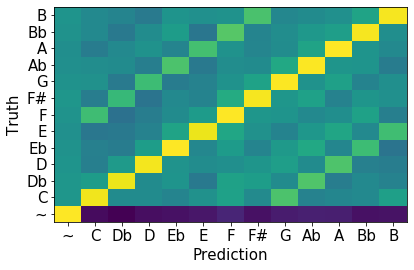

In [34]:
curr_metric = 'root_cmat_train'
ticks = np.arange(0,cmat.shape[1],1.0)
ticklabels = [chord_loader.num_to_root[x-1] for x in ticks]
ticks += 0.5
plt.pcolor(np.log(cmat))
#plt.pcolor(metrics[2][curr_metric])
plt.xticks(ticks=ticks, labels=ticklabels)
plt.yticks(ticks=ticks, labels=ticklabels)
plt.xlabel('Prediction')
plt.ylabel('Truth')
plt.rc('font', size=15)
plt.tight_layout()

Test that the new chord_train works.

```python chord_train.py partial_lr xgb_partial xgb --params T 10 5 0.1```

In [76]:
metrics = pickle.load(open("Models/xgb_partial_metrics.pkl", 'rb'))

In [65]:
#without weighting
print(f"Root F1 score: {metrics['root_F1_valid']}")
print(f"Quality F1 score: {metrics['quality_F1_valid']}")
print(f"Add F1 score: {metrics['add_F1_valid']}")
print(f"Inversion F1 score: {metrics['inv_F1_valid']}")
print(f"Total accuracy: {metrics['total_acc_valid']}")

Root F1 score: 0.04978459918603366
Quality F1 score: 0.6160150075885393
Add F1 score: 0.5120695646554685
Inversion F1 score: 0.9474185318468422
Total accuracy: 0.12281240405280934


Except for the root model, this is pretty good, especially for something that ran so quickly and can be expanded further.

## Focusing on XGB
Due to time constraints, I need to focus on just one model and tune the parameters.  Let's go with XGB, and switch later if it can't beat the random forest / logistic regression baseline.

### Max depth
Because a major constraint is disk space usage, I will vary max depth and num_estimators simultaneously, so as to take a constant amount of disk space.  First, figure out the space per estimator...

```python chord_train.py full xgb_d3 xgb --params T 1 3 0.1;
python chord_train.py full xgb_d5 xgb --params T 1 5 0.1;
python chord_train.py full xgb_d10 xgb --params T 1 10 0.1;
python chord_train.py full xgb_d15 xgb --params T 1 15 0.1;
```

In [66]:
metrics = [pickle.load(open("Models/xgb_d3_metrics.pkl", 'rb'))]
metrics.append(pickle.load(open("Models/xgb_d5_metrics.pkl", 'rb')))
metrics.append(pickle.load(open("Models/xgb_d10_metrics.pkl", 'rb')))

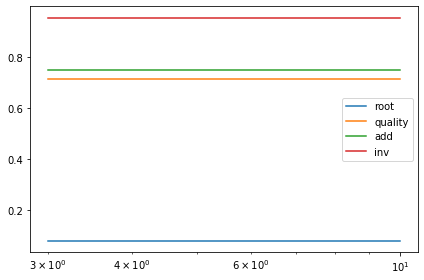

In [69]:
L2weight = [3,5,10]
plt.plot(L2weight, [m['root_acc_train'] for m in metrics]);
plt.plot(L2weight, [m['quality_acc_train'] for m in metrics]);
plt.plot(L2weight, [m['add_acc_train'] for m in metrics]);
plt.plot(L2weight, [m['inv_acc_train'] for m in metrics]);
plt.xscale('log')
plt.legend(['root','quality','add','inv'])
plt.tight_layout()

/anaconda3/envs/insight/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """


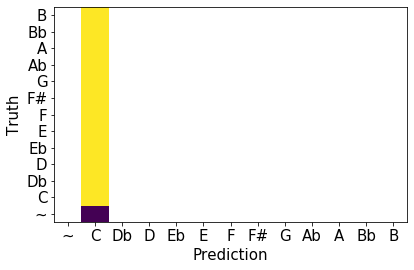

In [75]:
curr_metric = 'root_cmat_train'
ticks = np.arange(0,metrics[2][curr_metric].shape[1],1.0)
ticklabels = [chord_loader.num_to_root[x-1] for x in ticks]
ticks += 0.5
plt.pcolor(np.log(metrics[2][curr_metric]))
#plt.pcolor(metrics[2][curr_metric])
plt.xticks(ticks=ticks, labels=ticklabels)
plt.yticks(ticks=ticks, labels=ticklabels)
plt.xlabel('Prediction')
plt.ylabel('Truth')
plt.rc('font', size=15)
plt.tight_layout()